# Model Template

In [1]:
# import necessary packages

import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
# TODO: modell mit eurem ersetzen
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

# Empfohlen von sklearn als Alternative zu SVR, da besser skalierbar auf größere Datensätze
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor

c:\anaconda\envs\data-mining-bixi\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read data

train_df = pd.read_csv('data/preprocessed_data/train.csv')
val_df = pd.read_csv('data/preprocessed_data/validation.csv')
test_df = pd.read_csv('data/preprocessed_data/test.csv')
corona_df = pd.read_csv('data/preprocessed_data/corona.csv')

In [3]:
print(0 in train_df["elevation_meters"].values)

True


In [4]:
print(0 in train_df["density"].values)

True


<AxesSubplot:>

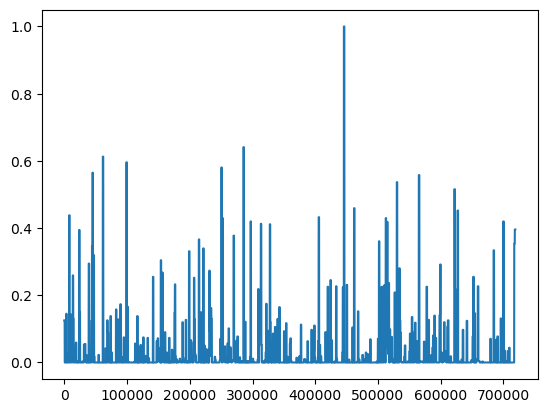

In [5]:
train_df["total_precipitation"].plot()

In [6]:
# drop start date for regression (is represented as month, day, pm) 
# train_df = train_df.drop(columns='start_date')
# test_df = test_df.drop(columns='start_date')

# drop null values
# train_df = train_df.dropna()
# val_df = val_df.dropna()
# test_df = test_df.dropna()

In [7]:
# scaler = StandardScaler()

# train_df = scaler.fit_transform(train_df) 
# val_df = scaler.fit_transform(val_df) 
# test_df = scaler.fit_transform(test_df)

In [7]:
train_df.isna().sum()

latitude               0
longitude              0
distance_to_center     0
year                   0
month                  0
weekday                0
pm                     0
holiday                0
mean_temperature       0
total_precipitation    0
stations_count         0
elevation_meters       0
density                0
count                  0
dtype: int64

In [8]:
# split data

X_train = train_df.drop(columns='count')
y_train = train_df['count']

X_val = val_df.drop(columns='count')
y_val = val_df['count']

X_test = test_df.drop(columns='count')
y_test = test_df['count']

X_corona = corona_df.drop(columns='count')
y_corona = corona_df['count']

## Support Vector Regression

In [10]:
# # hyperparameter tuning

# try:
#     # TODO: file-name ersetzen (in diesem File werden die Ergebnisse des Hyperparameter Tuning gespeichert)
#     hyperparameters_df = pd.read_csv('data/hyperparameter_tuning/SVR.csv')
    
# except FileNotFoundError:
    
#     # df containing hyperparameters and evaluation metrics of each run
#     hyperparameters_df = pd.DataFrame()
    
#     # this function is used by optuna to tune the hyperparameters
#     def objective(trial):
#         # TODO: die Hyperparameter mit denen eures Modells ersetzen
#         # - integers: trial.suggest_int(name, low, high)
#         # - floats: trial.suggest_int(name, low, high)
#         # - kategorisch: trial.suggest_categorical(name, choices)
#         # (https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.trial.Trial.html)
#         # define hyperparameters
#         kernel = trial.suggest_categorical('kernel', ['poly', 'rbf'])
#         gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
#         c_regularizaion = trial.suggest_float('C', 1, 100)
        
#         # TODO: mit eurem Modell ersetzen
#         # setup and train model
#         SVR_reg = SVR(
#             kernel=kernel,
#             gamma=gamma,
#             C=c_regularizaion
#         )
#         SVR_reg.fit(X_train, y_train)
        
#         # make predictions
#         y_val_pred = SVR_reg.predict(X_val)
        
#         # evaluate predictions
#         r_squared = r2_score(y_val, y_val_pred)
#         rmse = mean_squared_error(y_val, y_val_pred) ** 0.5
        
#         # TODO: mit euren Hyperparametern ersetzen
#         # insert results in dataframe
#         global hyperparameters_df
#         hyperparameters_df = hyperparameters_df.append(
#             {'kernel': kernel,
#              'gamma': gamma,
#              'C': c_regularizaion,
#              'r_squared': r_squared,
#              'rmse': rmse},
#             ignore_index=True
#         )
        
#         # return rmse -> optuna will optimize rmse
#         return rmse
        
        
#     study = optuna.create_study()
#     # start optimization
#     study.optimize(objective, n_trials=25)
    
#     # TODO: evtl. müsst ihr auch noch mal die Datentypen anpassen
#     # convert to correct data types
#     # hyperparameters_df[['n_estimators', 'max_depth']] = hyperparameters_df[['n_estimators', 'max_depth']].astype('int')
    
#     # sort hyperparameter tuning results and save file
#     hyperparameters_df = hyperparameters_df.sort_values('rmse', ascending=True)
#     hyperparameters_df = hyperparameters_df.reset_index(drop=True)
#     hyperparameters_df.to_csv('data/hyperparameter_tuning/SVR.csv', index=False)

In [11]:
# hyperparameters_df.head()

In [12]:
# # final model evaluation

# # TODO: mit eurem Modell und Hyperparametern ersetzen
# # build and train model using the most successful hyperparameters
# SVR_reg = SVR()
# SVR_reg.fit(X_train, y_train)

# # make predictions
# y_test_pred = SVR_reg.predict(X_test)

# # evaluate predictions
# r_squared = r2_score(y_test, y_test_pred)
# rmse = mean_squared_error(y_test, y_test_pred) ** 0.5

# print(f'R^2:\t{r_squared}')
# print(f'RMSE:\t{rmse}')

# LinearSVR

In [9]:
# hyperparameter tuning

try:
    # TODO: file-name ersetzen (in diesem File werden die Ergebnisse des Hyperparameter Tuning gespeichert)
    hyperparameters_df = pd.read_csv('data/hyperparameter_tuning/linearSVR.csv')
    
except FileNotFoundError:
    
    # df containing hyperparameters and evaluation metrics of each run
    hyperparameters_df = pd.DataFrame()
    
    # this function is used by optuna to tune the hyperparameters
    def objective(trial):
        # TODO: die Hyperparameter mit denen eures Modells ersetzen
        # - integers: trial.suggest_int(name, low, high)
        # - floats: trial.suggest_int(name, low, high)
        # - kategorisch: trial.suggest_categorical(name, choices)
        # (https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.trial.Trial.html)
        # define hyperparameters
        epsilon = trial.suggest_float('epsilon', 0, 1, step=0.1)
        loss = trial.suggest_categorical('loss', ['epsilon_insensitive', 'squared_epsilon_insensitive'])
        c_regularizaion = trial.suggest_float('C', 1, 100)
        
        # TODO: mit eurem Modell ersetzen
        # setup and train model
        LinearSVR_reg = LinearSVR(
            epsilon=epsilon,
            loss=loss,
            C=c_regularizaion,
            random_state=1
        )
        LinearSVR_reg.fit(X_train, y_train)
        
        # make predictions
        y_val_pred = LinearSVR_reg.predict(X_val)
        
        # evaluate predictions
        r_squared = r2_score(y_val, y_val_pred)
        rmse = mean_squared_error(y_val, y_val_pred) ** 0.5
        
        # TODO: mit euren Hyperparametern ersetzen
        # insert results in dataframe
        global hyperparameters_df
        hyperparameters_df = hyperparameters_df.append(
            { 'epsilon': epsilon,
            'loss': loss,
             'C': c_regularizaion,
             'r_squared': r_squared,
             'rmse': rmse},
            ignore_index=True
        )
        
        # return rmse -> optuna will optimize rmse
        return rmse
        
        
    study = optuna.create_study()
    # start optimization
    study.optimize(objective, n_trials=25)
    
    # TODO: evtl. müsst ihr auch noch mal die Datentypen anpassen
    # convert to correct data types
    hyperparameters_df['epsilon'] = hyperparameters_df['epsilon'].astype('float')
    hyperparameters_df['C'] = hyperparameters_df['C'].astype('int')
    
    # sort hyperparameter tuning results and save file
    hyperparameters_df = hyperparameters_df.sort_values('rmse', ascending=True)
    hyperparameters_df = hyperparameters_df.reset_index(drop=True)
    hyperparameters_df.to_csv('data/hyperparameter_tuning/linearSVR.csv', index=False)

In [10]:
hyperparameters_df.head()

,epsilon,loss,C,r_squared,rmse
0,1.0,squared_epsilon_insensitive,42,0.336076,21.384576
1,0.9,squared_epsilon_insensitive,40,0.336042,21.385113
2,0.9,squared_epsilon_insensitive,41,0.336032,21.385280
3,0.9,squared_epsilon_insensitive,34,0.336029,21.385331
4,0.9,squared_epsilon_insensitive,43,0.336005,21.385714


In [11]:
# build final model on test and validation data

X_final_train = pd.concat([X_train, X_val], ignore_index=True)
y_final_train = pd.concat([y_train, y_val], ignore_index=True)

In [12]:
# final model evaluation

# TODO: mit eurem Modell und Hyperparametern ersetzen
# build and train model using the most successful hyperparameters
LinearSVR_reg = LinearSVR(
            epsilon=hyperparameters_df.loc[0, 'epsilon'],
            loss=hyperparameters_df.loc[0, 'loss'],
            C=hyperparameters_df.loc[0, 'C'],
            random_state=1
)

LinearSVR_reg.fit(X_final_train, y_final_train)

# make predictions
y_test_pred = LinearSVR_reg.predict(X_test)

# evaluate predictions
r_squared = r2_score(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5

print(f'R^2:\t{r_squared}')
print(f'RMSE:\t{rmse}')

R^2:	0.33742155216490244
RMSE:	21.646914705258805


c:\anaconda\envs\data-mining-bixi\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [13]:
# predictions on corona year 2020

# make predictions
y_corona_pred = LinearSVR_reg.predict(X_corona)

# evaluate predictions
r_squared_c = r2_score(y_corona, y_corona_pred)
rmse_c = mean_squared_error(y_corona, y_corona_pred) ** 0.5

print(f'R^2:\t{r_squared_c}')
print(f'RMSE:\t{rmse_c}')

R^2:	-0.7257191821687019
RMSE:	20.565436901352967


In [ ]:
# from sklearn.feature_selection import RFECV

# SGD Regressor

In [ ]:
# hyperparameter tuning

try:
    # TODO: file-name ersetzen (in diesem File werden die Ergebnisse des Hyperparameter Tuning gespeichert)
    hyperparameters_df = pd.read_csv('data/hyperparameter_tuning/SGD_SVR.csv')
    
except FileNotFoundError:
    
    # df containing hyperparameters and evaluation metrics of each run
    hyperparameters_df = pd.DataFrame()
    
    # this function is used by optuna to tune the hyperparameters
    def objective(trial):
        # TODO: die Hyperparameter mit denen eures Modells ersetzen
        # - integers: trial.suggest_int(name, low, high)
        # - floats: trial.suggest_int(name, low, high)
        # - kategorisch: trial.suggest_categorical(name, choices)
        # (https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.trial.Trial.html)
        # define hyperparameters
        epsilon = trial.suggest_float('epsilon', 0, 1, step=0.1)
        loss = trial.suggest_categorical('loss', ['epsilon_insensitive', 'squared_epsilon_insensitive'])
        c_regularizaion = trial.suggest_float('C', 1, 100)
        
        # TODO: mit eurem Modell ersetzen
        # setup and train model
        SGDRegressor = SGDRegressor(
            epsilon=epsilon,
            loss=loss,
            C=c_regularizaion,
            random_state=1
        )
        SGDRegressor.fit(X_train, y_train)
        
        # make predictions
        y_val_pred = SGDRegressor.predict(X_val)
        
        # evaluate predictions
        r_squared = r2_score(y_val, y_val_pred)
        rmse = mean_squared_error(y_val, y_val_pred) ** 0.5
        
        # TODO: mit euren Hyperparametern ersetzen
        # insert results in dataframe
        global hyperparameters_df
        hyperparameters_df = hyperparameters_df.append(
            { 'epsilon': epsilon,
            'loss': loss,
             'C': c_regularizaion,
             'r_squared': r_squared,
             'rmse': rmse},
            ignore_index=True
        )
        
        # return rmse -> optuna will optimize rmse
        return rmse
        
        
    study = optuna.create_study()
    # start optimization
    study.optimize(objective, n_trials=25)
    
    # TODO: evtl. müsst ihr auch noch mal die Datentypen anpassen
    # convert to correct data types
    hyperparameters_df['epsilon'] = hyperparameters_df['epsilon'].astype('float')
    hyperparameters_df['C'] = hyperparameters_df['C'].astype('int')
    
    # sort hyperparameter tuning results and save file
    hyperparameters_df = hyperparameters_df.sort_values('rmse', ascending=True)
    hyperparameters_df = hyperparameters_df.reset_index(drop=True)
    hyperparameters_df.to_csv('data/hyperparameter_tuning/SGD_SVR.csv', index=False)